<a href="https://colab.research.google.com/github/YunusEmreBalkis/-Film-Archive/blob/master/animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import shutil
import os
import random
import cv2
import numpy as np
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [2]:
rrebirrth_animals_with_attributes_2_path = kagglehub.dataset_download('rrebirrth/animals-with-attributes-2')

print('Data source import complete.')

100%|██████████| 13.0G/13.0G [03:09<00:00, 73.7MB/s]

Extracting files...


Data source import complete.


In [3]:
image_paths = {}

base_path = "/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/"

animals = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]

for dirname, _, filenames in os.walk(base_path):
    for animal in animals:
        if animal in dirname:
            if animal not in image_paths:
                image_paths[animal] = []
            for filename in filenames:
                image_paths[animal].append(os.path.join(dirname, filename))

for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")

dolphin: 946 images
squirrel: 1200 images
fox: 664 images
elephant: 1038 images
collie: 1028 images
moose: 704 images
sheep: 1420 images
polar+bear: 868 images
giant+panda: 874 images
rabbit: 1088 images


In [4]:
for animal in image_paths:
  image_paths[animal] = image_paths[animal][:650]
for animal, paths in image_paths.items():
    print(f"{animal}: {len(paths)} images")
print(image_paths)

dolphin: 650 images
squirrel: 650 images
fox: 650 images
elephant: 650 images
collie: 650 images
moose: 650 images
sheep: 650 images
polar+bear: 650 images
giant+panda: 650 images
rabbit: 650 images
{'dolphin': ['/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/dolphin/dolphin_10085.jpg', '/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/dolphin/dolphin_10264.jpg', '/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/dolphin/dolphin_10297.jpg', '/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/dolphin/dolphin_10699.jpg', '/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2/versions/1/Animals_with_Attributes2/JPEGImages/dolphin/dolphin_10651.jpg', '/root/.cache/kagglehub/datasets/rrebirrth/animals-with-attributes-2

In [5]:
image_size = (128, 128)
output_dir = "resized_images"
os.makedirs(output_dir, exist_ok=True)
for animal, paths in image_paths.items():
    print(f"Processing {animal}...")
    for file_path in paths:
        try:
            file_path = os.path.abspath(file_path)
            input_image = cv2.imread(file_path)
            if input_image is None:
                print(f"Warning: Could not read image at {file_path}")
                continue

            img_resized = cv2.resize(input_image, image_size)
            img_normalized = img_resized / 255.0

            output_filename = os.path.basename(file_path)
            output_path = os.path.join(output_dir, animal + "_" + output_filename)
            cv2.imwrite(output_path, (img_normalized * 255).astype('uint8'))
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

print("Image resizing and normalization completed.")

Processing dolphin...
Processing squirrel...
Processing fox...
Processing elephant...
Processing collie...
Processing moose...
Processing sheep...
Processing polar+bear...
Processing giant+panda...
Processing rabbit...
Image resizing and normalization completed.


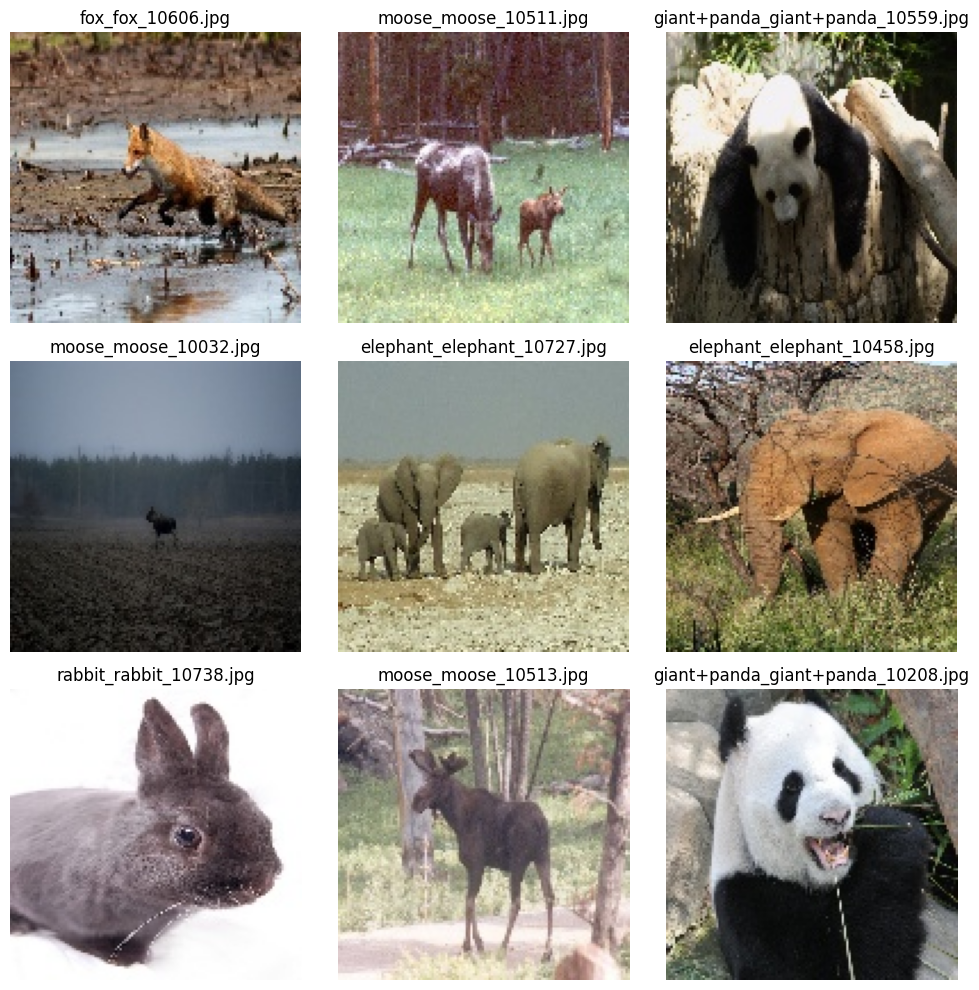

In [6]:
image_folder = "resized_images"

image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))]
batch_size = 9
selected_images = random.sample(image_files, batch_size)

rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, ax in enumerate(axes.flat):
    if i < len(selected_images):
        img = cv2.imread(selected_images[i])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(os.path.basename(selected_images[i]))
        ax.axis('off')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()

In [7]:
image_folder = "resized_images"
X, y = [], []

for filename in os.listdir(image_folder):
    if filename.endswith(('.png', '.jpg', '.jpeg')):

        file_path = os.path.join(image_folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            X.append(img)

            label = filename.split('_')[0]
            y.append(label)

X = np.array(X)
y = np.array(y)

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)

print(f"Total images: {len(X)}")
print(f"Training set: {len(X_train)} images")
print(f"Testing set: {len(X_test)} images")
print(f"Classes: {encoder.classes_}")

Total images: 6500
Training set: 4550 images
Testing set: 1950 images
Classes: ['collie' 'dolphin' 'elephant' 'fox' 'giant+panda' 'moose' 'polar+bear'
 'rabbit' 'sheep' 'squirrel']



# Data Augmentation

In [8]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [9]:
def build_model():
     model = Sequential([
     layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(64, (3, 3), activation='relu'),
     layers.MaxPooling2D((2, 2)),
     layers.Conv2D(128, (3, 3), activation='relu'),
     layers.MaxPooling2D((2, 2)),

     layers.Flatten(),
     layers.Dense(512, activation='relu'),
     layers.Dropout(0.5),
     layers.Dense(10, activation='softmax')
 ])
     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
     model.summary()
     return model


In [10]:
def build_alternate_model():
    model = Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()
    return model


In [11]:
model = build_model()
history = model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=100, validation_data=(X_test, y_test))
model.save('animal_classifier.h5')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,943,946 (49.38 MB)

 Trainable params: 12,943,946 (49.38 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 29s 158ms/step - accuracy: 0.1723 - loss: 30.3047 - val_accuracy: 0.1533 - val_loss: 2.2621
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 134ms/step - accuracy: 0.1635 - loss: 2.2438 - val_accuracy: 0.1062 - val_loss: 2.2924
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 130ms/step - accuracy: 0.1440 - loss: 2.3035 - val_accuracy: 0.1933 - val_loss: 2.1748
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 19s 136ms/step - accuracy: 0.1941 - loss: 2.1784 - val_accuracy: 0.1938 - val_loss: 2.3458
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.2240 - loss: 2.1363 - val_accuracy: 0.1867 - val_loss: 2.1194
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 126ms/step - accuracy: 0.1940 - loss: 2.1557 - val_accuracy: 0.1990 - val_loss: 2.1125
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 138ms/step - accuracy: 0.1786 - loss: 2.1578 - val_accuracy: 0.1821 - val_loss: 2.1564
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 128ms/step - accuracy: 0.2250 

In [12]:
alternate_model = build_alternate_model()
history_alt = alternate_model.fit(datagen.flow(X_train, y_train, batch_size=32),epochs=100,validation_data=(X_test, y_test))
alternate_model.save('alternate_animal_classifier.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │      25,690,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,197,130 (99.93 MB)

 Trainable params: 26,196,234 (99.93 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 40s 210ms/step - accuracy: 0.2021 - loss: 4.7834 - val_accuracy: 0.2769 - val_loss: 3.0899
Epoch 2/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 141ms/step - accuracy: 0.2605 - loss: 3.1380 - val_accuracy: 0.3472 - val_loss: 2.9598
Epoch 3/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.2685 - loss: 3.0612 - val_accuracy: 0.3821 - val_loss: 2.8373
Epoch 4/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.2825 - loss: 3.0294 - val_accuracy: 0.3846 - val_loss: 2.7562
Epoch 5/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 152ms/step - accuracy: 0.3141 - loss: 2.9599 - val_accuracy: 0.4082 - val_loss: 2.6998
Epoch 6/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 143ms/step - accuracy: 0.3341 - loss: 2.9031 - val_accuracy: 0.4113 - val_loss: 2.6492
Epoch 7/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 21s 148ms/step - accuracy: 0.3606 - loss: 2.8056 - val_accuracy: 0.4128 - val_loss: 2.6157
Epoch 8/100
143/143 ━━━━━━━━━━━━━━━━━━━━ 20s 137ms/step - accuracy: 0.3576 -

In [13]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

alternate_test_loss_alt, alternate_test_accuracy_alt = alternate_model.evaluate(X_test, y_test)

print(f"Alternate Model Test Loss: {alternate_test_loss_alt}")
print(f"Alternate Model Test Accuracy: {alternate_test_accuracy_alt * 100:.2f}%")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6325 - loss: 1.1528
Test Loss: 1.1292403936386108
Test Accuracy: 63.90%
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7505 - loss: 1.4583
Alternate Model Test Loss: 1.4560092687606812
Alternate Model Test Accuracy: 74.46%


In [14]:
def get_manipulated_images(images):
    manipulated_images = []
    for img in images:
        manipulated_img = cv2.convertScaleAbs(img, alpha=random.uniform(0.5, 1.5), beta=random.randint(-50, 50))
        manipulated_images.append(manipulated_img)
    return np.array(manipulated_images)

x_test_manipulated = get_manipulated_images(X_test)

test_loss_manipulated, test_accuracy_manipulated = model.evaluate(x_test_manipulated, y_test)
print(f"Manipulated Test Set Accuracy: {test_accuracy_manipulated:.4f}")

alternate_test_loss_manipulated, alternate_test_accuracy_manipulated = alternate_model.evaluate(x_test_manipulated, y_test)
print(f"Alternate Model Manipulated Test Set Accuracy:: {alternate_test_accuracy_manipulated:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5708 - loss: 1.4223
Manipulated Test Set Accuracy: 0.5821
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6611 - loss: 1.7402
Alternate Model Manipulated Test Set Accuracy:: 0.6662


In [15]:
def get_wb_images(images):
    wb_images = []
    for img in images:
        avg_bgr = np.mean(img, axis=(0, 1))
        gray_world_img = img * (avg_bgr.mean() / avg_bgr)
        wb_images.append(np.clip(gray_world_img, 0, 255).astype(np.uint8))
    return np.array(wb_images)

x_test_wb = get_wb_images(x_test_manipulated)

test_loss_wb, test_accuracy_wb = model.evaluate(x_test_wb, y_test)
print(f"Color Stability Applied Test Set Accuracy: {test_accuracy_wb:.4f}")

alternate_test_loss_wb, alternate_test_accuracy_wb = alternate_model.evaluate(x_test_wb, y_test)
print(f"Alternate Model Color Stability Applied Test Set Accuracy {alternate_test_accuracy_wb:.4f}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4574 - loss: 1.8053
Color Stability Applied Test Set Accuracy: 0.4518
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5704 - loss: 2.0523
Alternate Model Color Stability Applied Test Set Accuracy 0.5559


In [16]:
print("Results:")
print(f"Original Test Set Accuracy: {test_accuracy * 100:.2f}%")
print(f"Manipulated Test Set Accuracy: {test_accuracy_manipulated * 100:.2f}%")
print(f"Test Set Accuracy with Color Constancy Applied: {test_accuracy_wb * 100:.2f}%")

print(f"Alternate Model Original Test Set Accuracy: {alternate_test_accuracy_alt * 100:.2f}%")
print(f"Alternate Model Manipulated Test Set Accuracy: {alternate_test_accuracy_manipulated * 100:.2f}%")
print(f"Alternate Model Test Set Accuracy with Color Constancy Applied: {alternate_test_accuracy_wb * 100:.2f}%")

Results:
Original Test Set Accuracy: 63.90%
Manipulated Test Set Accuracy: 58.21%
Test Set Accuracy with Color Constancy Applied: 45.18%
Alternate Model Original Test Set Accuracy: 74.46%
Alternate Model Manipulated Test Set Accuracy: 66.62%
Alternate Model Test Set Accuracy with Color Constancy Applied: 55.59%
